In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets
iris = datasets.load_iris()

In [5]:
#petal length & width
X = iris['data'][:100,(2,3)]
y = iris['target'][:100]

In [7]:
y[y == 0] = y[y == 0] - 1

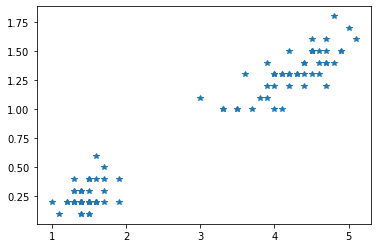

In [8]:
f1,ax1 = plt.subplots()
ax1.plot(X[:,0],X[:,1],'*')

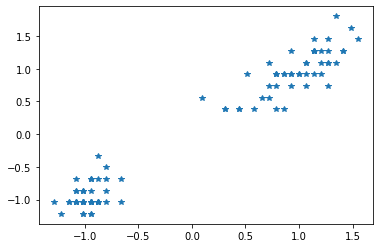

In [9]:
from sklearn.preprocessing import StandardScaler

sclaler = StandardScaler()
X_scaled = sclaler.fit_transform(X)
f2,ax2 = plt.subplots()
ax2.plot(X_scaled[:,0],X_scaled[:,1],'*')

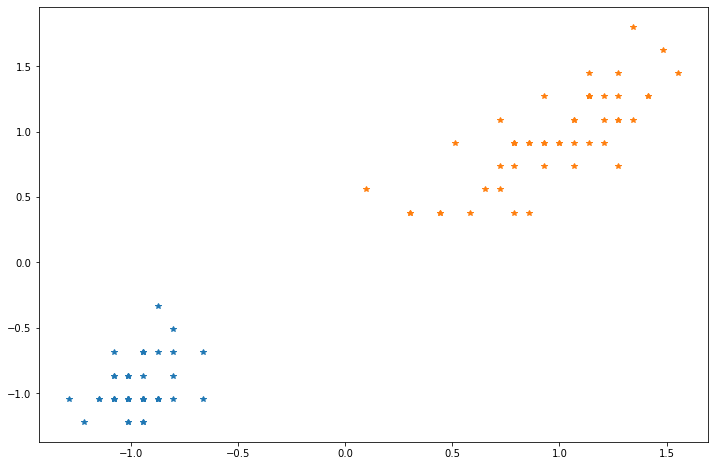

In [10]:
import pandas as pd 
import numpy as np



df = pd.DataFrame(np.c_[X_scaled,y])
df.columns = ["petalLength", "petalWidth", "target"]
df_grouped = df.groupby('target')
f3,ax3 = plt.subplots(figsize=(12,8))
for target , gr in df_grouped:
    ax3.plot(gr.petalLength,gr.petalWidth,'*',label = 'target')

In [11]:
[x0Min,x0Max] = [min(X_scaled[:,0]) - 0.1 , max(X_scaled[:,0]) + 0.1]
[x1Min,x1Max] = [min(X_scaled[:,1]) - 0.1 , max(X_scaled[:,1]) + 0.1]

In [12]:
delta = 0.01
[x0Plt,x1Plt] = np.meshgrid(np.arange(x0Min,x0Max,delta),np.arange(x1Min,x1Max,delta))

In [13]:
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

#cvxopt 라이브러리를 이용하여 QP 해 구하기

y = y.reshape(-1,1) * 1.
X_dash = y * X_scaled
H = np.dot(X_dash,X_dash.T) * 1.

Quadratic Programming

\begin{aligned}
    & \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ & \ Gx \leq h 
    \\
    & \ Ax = b
\end{aligned}


Lagrangian dual problem 

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
    & s.t. \ - \alpha_i \leq 0 
    \\
    & s.t. \ y^T \alpha = 0 
\end{aligned}


softmax margin SVM 

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
     s.t. & \ - \alpha_i \leq 0 
    \\
     & \alpha_i \leq C
     \\
     &\ y^T \alpha = 0  
\end{aligned}


In [14]:
m , n = X.shape
C = 0.01

P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m,1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1,-1))
b = cvxopt_matrix(np.zeros(1))

In [15]:
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -3.1323e+00 -1.6492e+00  4e+02  2e+01  8e-16
 1: -3.3824e-01 -1.6268e+00  6e+00  3e-01  9e-16
 2: -2.9391e-01 -1.1179e+00  8e-01  4e-17  3e-16
 3: -3.1303e-01 -4.2146e-01  1e-01  1e-17  2e-16
 4: -3.4466e-01 -3.6018e-01  2e-02  2e-17  2e-16
 5: -3.5145e-01 -3.5499e-01  4e-03  6e-17  1e-16
 6: -3.5267e-01 -3.5405e-01  1e-03  8e-17  1e-16
 7: -3.5318e-01 -3.5352e-01  3e-04  2e-17  1e-16
 8: -3.5335e-01 -3.5335e-01  5e-06  3e-17  2e-16
 9: -3.5335e-01 -3.5335e-01  5e-08  1e-16  1e-16
Optimal solution found.


In [16]:
#w 
w = ((y * alphas).T @ X_scaled).reshape(-1,1)

# 서포트 벡터만 선택
S = (alphas > 1e-4).flatten()

#Computing b
b = y[S] - np.dot(X_scaled[S], w)

print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.00905421 0.01       0.00999999 0.00905421 0.00905421 0.00999999
 0.01       0.01       0.00999999 0.01       0.01       0.00999999
 0.01       0.01       0.01       0.00999999 0.01       0.00905421
 0.00999999 0.00999999 0.01       0.00905421 0.00905421 0.00999997
 0.00999997 0.01       0.01       0.00999999 0.00999999 0.00905421
 0.01       0.01       0.01       0.00999998 0.01       0.01
 0.01       0.01       0.00168972 0.01       0.01       0.01
 0.01       0.01       0.00168972 0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01      ]
w =  [0.49629689 0.46958182]
b =  [-0.04231653]


In [17]:
mat_x = np.c_[x0Plt.ravel(),x1Plt.ravel()]
h = mat_x @ w + b[0]
h = h.reshape(x0Plt.shape)

<a list of 8 text.Text objects>

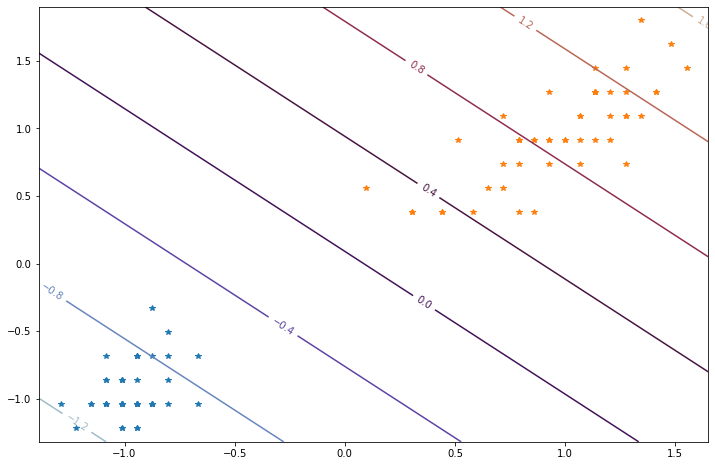

In [18]:
f3,ax3 = plt.subplots(figsize=(12,8))

for target , gr in df_grouped:
    ax3.plot(gr.petalLength,gr.petalWidth,'*',label = 'target')

CS = ax3.contour(x0Plt,x1Plt,h,cmap=plt.cm.twilight)

ax3.clabel(CS)

sklearn svc 와 비교

In [19]:
from sklearn.svm import SVC

svm_clf = SVC(C=0.01 , kernel='linear')
svm_clf.fit(X_scaled,y)

c:\Users\outof\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.01, kernel='linear')

In [163]:
svm_clf.coef_

array([[0.49629694, 0.46958183]])

In [164]:
svm_clf.intercept_

array([-0.04231646])